# Environment Setup

In [0]:
# Run then restart runtime
!apt-get install python3-rtree
!pip install pystac
!pip install geopandas
!pip install rio-tiler
!pip install descartes
!pip install rasterio
!pip install solaris==0.2.0


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 25 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg

     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 14.7MB 43.9MB/s 
     |████████████████████████████████| 10.4MB 45.0MB/s 
     |████████████████████████████████| 122kB 3.5MB/s 
     |████████████████████████████████| 18.0MB 257kB/s 
  Created wheel for rio-tiler: filename=rio_tiler-1.4.0-cp36-none-any.whl size=173020 sha256=375851dde278c3ef010c7d95048cb788e8606d4ed8ed5a2cc41dd920c7635db6
  Stored in directory: /root/.cache/pip/wheels/c4/f1/d3/60b689580c9701d5b5332d8fe3675a3c8a8c8342e192e3a8d5
  Created wheel for rio-toa: filename=rio_toa-0.3.0-cp36-none-any.whl size=12428 sha256=10467ca030c744c17436e7ba4ee6daef1cff5c9b0a2ca6f2f55cf217bf3cfb14
  Stored in directory: /root/.cache/pip/wheels/12/25/52/036fe06fa14768bf5e4eef4abd4beccb3924b695199f1721a2
Successfully built rio-tiler rio-toa
     |████████████████████████████████| 10.2MB 3.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 3.2MB 51

In [0]:
# restarts runtime
import os
os._exit(00)

In [0]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import solaris as sol
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

# We have to add this wrkaround for stackio:
# (https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io)
from urllib.parse import urlparse
import requests
from pystac import STAC_IO
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)
STAC_IO.read_text_method = my_read_method

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
# Folder Setup
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

# Loading the data

In [0]:
# load our training and test catalogs
train1_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/catalog.json')
train2_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_2/catalog.json')
test_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/test/catalog.json')
cols = {cols.id:cols for cols in train1_cat.get_children()}

In [0]:
# Get a list of the possible areas ('scenes) and ids
areas = []
for c in cols:
  itms = [x for x in cols[c].get_all_items()]
  for i, id in enumerate(itms):
    if i % 2 == 0 and i+1 < len(itms):
      areas.append((c, itms[i].id, itms[i+1].id))
print(areas)

[('acc', '665946', '665946-labels'), ('acc', 'a42435', 'a42435-labels'), ('acc', 'ca041a', 'ca041a-labels'), ('acc', 'd41d81', 'd41d81-labels'), ('mon', '401175', '401175-labels'), ('mon', '493701', '493701-labels'), ('mon', '207cc7', '207cc7-labels'), ('mon', 'f15272', 'f15272-labels'), ('ptn', 'abe1a3', 'abe1a3-labels'), ('ptn', 'f49f31', 'f49f31-labels'), ('kam', '4e7c7f', '4e7c7f-labels'), ('dar', 'a017f9', 'a017f9-labels'), ('dar', 'b15fce', 'b15fce-labels'), ('dar', '353093', '353093-labels'), ('dar', 'f883a0', 'f883a0-labels'), ('dar', '42f235', '42f235-labels'), ('dar', '0a4c40', '0a4c40-labels'), ('znz', '33cae6', '33cae6-labels'), ('znz', '3b20d4', '3b20d4-labels'), ('znz', '076995', '076995-labels'), ('znz', '75cdfa', '75cdfa-labels'), ('znz', '9b8638', '9b8638-labels'), ('znz', '06f252', '06f252-labels'), ('znz', 'c7415c', 'c7415c-labels'), ('znz', 'aee7fd', 'aee7fd-labels'), ('znz', '3f8360', '3f8360-labels'), ('znz', '425403', '425403-labels'), ('znz', 'bd5c14', 'bd5c14-l

# Getting the data into a useful form

Ideally, we'd like images in nice squares with the labels as masks - then we can follow normal image segmentation workflows. Currently, the data is all in a stac. This code takes an area (scene), splits it into tiles at a given zoom level (19 works well to see several buildings) and saves each tile + a mask representing the building fotprints. 

Set greyscale=False to get a 3-channel mask with footprints, outlines and contact areas. 

Apologies for the lack of documentation, but for more info and the source of a lot of this code see 
- https://gist.github.com/daveluo/57ada6ba61ff7c947aad8d6aaeeeb9e4
- https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321

I've also made some of the data available already here: https://www.kaggle.com/johnowhitaker/opencities-masked-256

I'll be working on making a more complete tutorial from start to finish, but I hope this is useful in the meantime.

In [0]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False, greyscale=True):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  if greyscale:
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask[:,:,0], check_contrast=False) 
  else:
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

In [0]:
def save_area_id_images(area = 'acc', img_id = 'ca041a', label_id='ca041a-labels', zoom_level = 19, tile_size = 256):

  # The item
  one_item = cols[area].get_item(id=img_id)

  # Load labels shapefile
  lab = cols[area].get_item(id=label_id)
  gdf = gpd.read_file(lab.make_asset_hrefs_absolute().assets['labels'].href)
  # get the geometries from the geodataframe
  all_polys = gdf.geometry

  # Get outlines as polygons
  polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0])
  polygon = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polygon_geom])   

  # Tile at zoom_level
  polygon['geometry'].to_file(img_id+'.geojson', driver='GeoJSON')
  !cat {img_id}.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > {img_id}{zoom_level}tiles.geojson

  # Load tiles
  tiles = gpd.read_file(f'{img_id}{zoom_level}tiles.geojson')

  # Add a convenience column
  tiles['xyz'] = tiles.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tiles['xyz'] = [[int(q) for q in p] for p in tiles['xyz']]

  # IMG URL
  tif_url = one_item.assets['image'].href

  # Sometimes it's just ./id.tif - add full path (should maybe use make_asset_hrefs_absolute instead!!)
  if tif_url.startswith("./"):
    tif_url = '/'.join(one_item.to_dict()['links'][1]['href'].split("/")[:-1])+tif_url[1:]

  print("TIF URL:", tif_url)

  print("Number of tiles:", len(tiles))

  # Loop through tiles, downloading and saving
  for idx in range(len(tiles)):
    tile, mask = rt_main.tile(tif_url, *tiles.iloc[idx]['xyz'], tilesize=tile_size)

    tile_poly = tiles.iloc[idx]['geometry']

    # get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
    tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 

    # crop geometries to what overlaps our tile polygon bounds
    cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
    cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs='epsg:4326')

    # burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
    fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf, channels=['footprint', 'boundary'], affine_obj=tfm, shape=(tile_size,tile_size),boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

    save_tile_img(tif_url, tiles.iloc[idx]['xyz'], tile_size, save_path=img_path, prefix=f'{area}_{img_id}_{idx}_', display=False)
    save_tile_mask(all_polys, tile_poly, tiles.iloc[idx]['xyz'], tile_size, save_path=mask_path,prefix=f'{area}_{img_id}_{idx}_', display=False)
    print("Saved", f'{area}_{img_id}_{idx}_')

In [0]:
save_area_id_images(area = 'acc', img_id = '665946', label_id='665946-labels', zoom_level = 19, tile_size = 256)

TIF URL: https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/acc/665946/665946.tif
Number of tiles: 459
Saved acc_665946_0_
Saved acc_665946_1_
Saved acc_665946_2_
Saved acc_665946_3_
Saved acc_665946_4_
Saved acc_665946_5_
Saved acc_665946_6_
Saved acc_665946_7_
Saved acc_665946_8_
Saved acc_665946_9_
Saved acc_665946_10_
Saved acc_665946_11_
Saved acc_665946_12_
Saved acc_665946_13_
Saved acc_665946_14_
Saved acc_665946_15_
Saved acc_665946_16_
Saved acc_665946_17_
Saved acc_665946_18_
Saved acc_665946_19_
Saved acc_665946_20_
Saved acc_665946_21_
Saved acc_665946_22_
Saved acc_665946_23_
Saved acc_665946_24_
Saved acc_665946_25_
Saved acc_665946_26_
Saved acc_665946_27_
Saved acc_665946_28_
Saved acc_665946_29_
Saved acc_665946_30_
Saved acc_665946_31_
Saved acc_665946_32_
Saved acc_665946_33_
Saved acc_665946_34_
Saved acc_665946_35_
Saved acc_665946_36_
Saved acc_665946_37_
Saved acc_665946_38_
Saved acc_665946_39_
Saved acc_665946_40_
Save

In [0]:
# TO save for later w drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Compress
!tar -czf my_data.tar.gz data

In [0]:
# copy training data compressed tarball to drive
!cp my_data.tar.gz /content/drive/My\ Drive/ 

In [0]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

# Check that it worked!

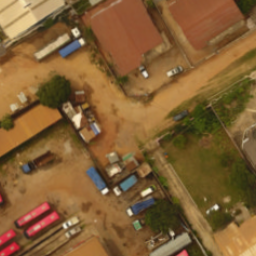

In [0]:
# Pick a random tile
import glob, random
from IPython.display import Image as SHOW_IM
images = glob.glob('/content/drive/My Drive/Colab Notebooks/data/images-256/*.png')
im = random.choice(images)
SHOW_IM(im)

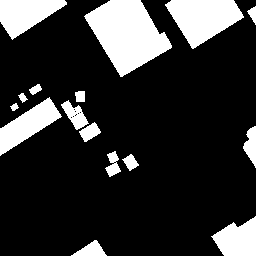

In [0]:
SHOW_IM(im.replace('images', 'masks').replace('.png', '_mask.png')) # The corresponding mask

In [0]:
# You could fetch all the data with:
# for a in areas:
#   save_area_id_images(area = a[0], img_id = a[1], label_id=a[2], zoom_level = 19, tile_size = 256)

In [1]:
import cv2
from google.colab.patches import cv2_imshow #Cannot use cv2.imshow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
import glob, random
from sklearn.metrics import jaccard_score

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [27]:
#Define model
model = Sequential([
    Dense( 600, input_shape = (65536,), activation='relu' ),
    Dropout(0.5),
    # Dense(600 , activation='relu' ),
    Dense( 600 , activation='relu' ),
    Dropout(0.25), 
    # Dense( 1000 , activation='relu' ),
    Dense( 600 , activation='relu' ),
    Dropout(0.5),
    # Dense( 1000 , activation='relu' ),
    Dense( 344,  activation='sigmoid' )
])

#compile model using mse as a measure of model performance
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae', 'mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 600)               39322200  
_________________________________________________________________
dropout_13 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 600)               360600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 600)               360600    
_________________________________________________________________
dropout_15 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 344)              

In [35]:
#Load data and train model 
def load_to_grayim(im_path):
  original_im = cv2.imread(im_path)
  return cv2.cvtColor(original_im, cv2.COLOR_BGR2GRAY)

def grayim_to_binary(im_array):
  return im_array/255

images = glob.glob('/content/drive/My Drive/Colab Notebooks/data/images-256/*.png')
cutoff_point = int(len(images)*0.75)
train_set = images[:cutoff_point]
test_set = images[cutoff_point:]

X, Y = [], []
for im in train_set:
  im_mask =  im.replace('images', 'masks').replace('.png', '_mask.png')
  
  im_data = load_to_grayim(im).reshape(65536, 1)
  im_mask_data = load_to_grayim(im_mask).reshape(65536, 1)
  X.append(im_data)
  Y.append( grayim_to_binary( im_mask_data) )

  # #Fit model
 $ model.fit(im_data, im_mask_data)
  


ValueError: ignored

In [23]:
len(X[1])

65536

In [0]:
X = np.array(X).reshape(65536,344)
Y = np.array(Y).reshape(65536,344)

In [33]:
history = model.fit(X, Y, batch_size= 1, epochs= 10)

ValueError: ignored

In [0]:
#Evaluate results
test_set = images[cutoff_point:]
def show_im_from_binary(data_bin):
  cv2_imshow( data_bin.reshape(256, 256)*255 )

def show_im_from_path(path):
  cv2_imshow( cv2.imread(path) )

X_test, Y_test = [], []
jaccards = []
for im in test_set:
  im_mask =  im.replace('images', 'masks').replace('.png', '_mask.png')
  
  im_data = load_to_grayim(im).reshape(1, 65536)
  y_pred = model.predict(im_data).astype(int)

  im_mask_data = load_to_grayim(im_mask).reshape(1, 65536)
  y_true = np.where(im_mask_data == 255, 1, im_mask_data)
  # X_test.append(im_data)
  # Y_test.append(im_mask_data)

  jaccards.append( jaccard_score(y_true, y_pred, average= 'micro') )

  #Show real image and pred image
  print('-'*10, im, '-'*10, '\n Real IM')
  show_im_from_path( im_mask )
  print('Predict IM')
  show_im_from_binary(y_pred)
np.mean( jaccards )  